In [ ]:
%pip install torchvision

In [ ]:
%pip install torch

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from typing import Tuple, List, Dict, Generator, Any
from IPython.display import clear_output
import cv2
from io import BytesIO
import os


In [ ]:
import src.create_mask as mask
import src.tensor as tensor
from src.metrics import metric_pixel_accuracy, metric_iou
from src.predict import predict
from src.train import train
from src.test import test
from src.tensor_func import image_preprocess

In [12]:
classes = {
    (0, 0, 0): (0, '__background__'),
    (255, 255, 255): (1, 'private_sectors'),
}

classes_by_id = dict()
for rgb, (id, name) in classes.items():
  classes_by_id[id] = (rgb, name)

In [13]:
save_dataset_subimages(
    classes_filter={
        (255, 255, 255): 5
    }
)

In [76]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i12si9')

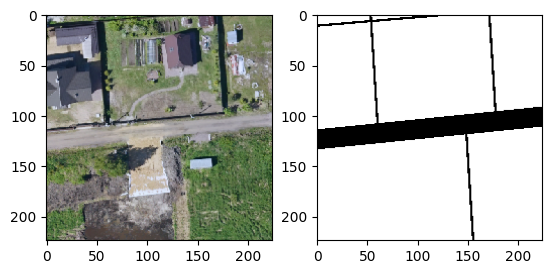

In [27]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled)
plt.show()


## VIEW

In [35]:
subimage_mask = get_image_mask_from_labeled(
    image_labeled=subimage_labeled,
    classes=classes
)


In [36]:
subimage_labeled_from_mask = get_image_labeled_from_mask(
    image_mask=subimage_mask,
    classes_by_id=classes_by_id
)

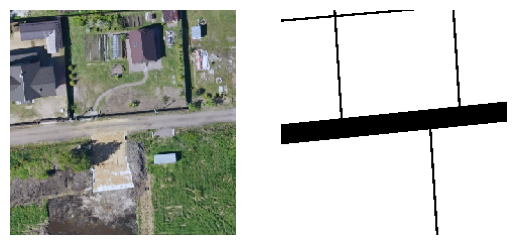

In [77]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[0].axis('off')
ax[1].imshow(subimage_labeled_from_mask)
ax[1].axis('off')
plt.show()

## INIT

In [38]:
train_dataset_subimages_id, test_dataset_subimages_id = train_test_split(get_dataset_subimages_id(), train_size=0.9)


In [39]:
train_dataset = Dataset(
    dataset_subimages_id=train_dataset_subimages_id,
    classes=classes,
)
test_dataset = Dataset(
    dataset_subimages_id=test_dataset_subimages_id,
    classes=classes
)

In [40]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1
)

## MODEL

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=len(classes),
    weights_backbone=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).to(device=device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 31.1MB/s]


## Метрики

In [43]:
def metric_pixel_accuracy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_argmax = y_pred.argmax(dim=1)
  y_true_argmax = y_true.argmax(dim=1)

  correct_pixels = (y_pred_argmax == y_true_argmax).count_nonzero()
  uncorrect_pixels = (y_pred_argmax != y_true_argmax).count_nonzero()
  result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

  return result


In [44]:
def metric_iou(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  intersection = torch.logical_and(y_pred_hot, y_true).count_nonzero()
  union = torch.logical_or(y_pred_hot, y_true).count_nonzero()
  result = (intersection / union).item()

  return result

## Обучение

In [45]:
def train(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    train_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
    optim_fn: Any,
    epochs: int
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'pixel_accuracy': list(),
      'iou': list()
  }

  for e in range(1, epochs + 1):
    for b, data in enumerate(train_dataloader, start=1):
      subimage_tensor, subimage_mask_tensor = data

      if device.type == 'cuda':
        subimage_tensor = subimage_tensor.to(device)
        subimage_mask_tensor = subimage_mask_tensor.to(device)

      optim_fn.zero_grad()
      output = model(subimage_tensor)
      loss = loss_fn(output['out'], subimage_mask_tensor)
      loss.backward()
      optim_fn.step()

      loss_item = loss.item()
      pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
      iou = metric_iou(output['out'], subimage_mask_tensor)

      history_metrics['loss'].append(loss_item)
      history_metrics['pixel_accuracy'].append(pixel_accuracy)
      history_metrics['iou'].append(iou)

      # dynamic output
      clear_output()
      print(
          'Epoch: {}. Batch: {}. Loss: {:.3f} | Pixel Accuracy: {:.3f} | IoU: {:.3f}'.format(
              e, b,
              loss, pixel_accuracy, iou
          )
      )

      # memory clear
      del subimage_tensor, subimage_mask_tensor, output, loss
      if device.type == 'cuda':
        torch.cuda.empty_cache()

  return history_metrics

In [46]:
history_metrics = train(
    model=model,
    device=device,
    train_dataloader=train_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optim_fn=torch.optim.AdamW(params=model.parameters(), lr=1e-4),
    epochs=8
)

Epoch: 8. Batch: 20. Loss: 0.179 | Pixel Accuracy: 0.938 | IoU: 0.873


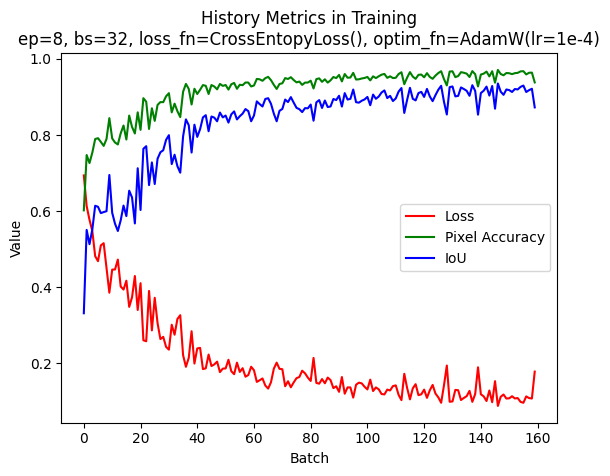

In [47]:
plt.plot(
    history_metrics['loss'], 'red',
    history_metrics['pixel_accuracy'], 'green',
    history_metrics['iou'], 'blue',
)
plt.title('History Metrics in Training\nep=8, bs=32, loss_fn=CrossEntopyLoss(), optim_fn=AdamW(lr=1e-4)')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend(('Loss', 'Pixel Accuracy', 'IoU'))
plt.show()

In [48]:
torch.save(model.state_dict(), 'model8epoch1_fcn_resnet101_ep8bs32lr1e-4.h5')

## TEST

In [49]:
def test(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
) -> Dict[str, List[float]]:

  history_metrics = {
      'pixel_accuracy': list(),
      'iou': list()
  }

  for b, data in enumerate(test_dataloader, start=1):
    subimage_tensor, subimage_mask_tensor = data

    if device.type == 'cuda':
      subimage_tensor = subimage_tensor.to(device)
      subimage_mask_tensor = subimage_mask_tensor.to(device)

    with torch.no_grad():
      output = model(subimage_tensor)

    pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
    iou = metric_iou(output['out'], subimage_mask_tensor)

    history_metrics['pixel_accuracy'].append(pixel_accuracy)
    history_metrics['iou'].append(iou)

    clear_output()
    print(
        'Batch: {}. median Pixel Accuracy: {:.3f} | median IoU: {:.3f}'.format(
            b,
            np.median(a=history_metrics['pixel_accuracy']),
            np.median(a=history_metrics['iou'])
        )
    )

    # memory clear
    del subimage_tensor, subimage_mask_tensor, output
    if device.type == 'cuda':
      torch.cuda.empty_cache()

  return history_metrics

In [50]:
test_history_metrics = test(
    model=model,
    device=device,
    test_dataloader=test_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss()
)

Batch: 70. median Pixel Accuracy: 0.688 | median IoU: 0.506


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16,8))
for si, (subimage_tensor, subimage_mask_tensor) in enumerate(test_dataloader):
  subimage = torchvision.transforms.ToPILImage()(pic=subimage_tensor[0])
  subimage_labeled = get_image_labeled_from_mask(
      image_mask=subimage_mask_tensor[0].cpu().numpy(),
      classes_by_id=classes_by_id
  )
  predicted_subimage_labeled = predict(
      image=subimage,
      model=model,
      device=device
  )
  ax[0][si].imshow(subimage)
  ax[0][si].axis('off')
  ax[0][si].set_title('Изображение', fontsize=12)
  ax[1][si].imshow(predicted_subimage_labeled)
  ax[1][si].axis('off')
  ax[1][si].set_title('Маска сегментации', fontsize=12)
  ax[2][si].imshow(subimage_labeled)
  ax[2][si].axis('off')
  ax[2][si].set_title('Эталон', fontsize=12)

  if si == 5 - 1:
    break

plt.show()

## Предикция

In [52]:
def predict(
    image: Image.Image,
    model: torch.nn.Module,
    device: torch.DeviceObjType,
) -> Image.Image:

  image_tensor = image_preprocess(image=image)

  with torch.no_grad():
    output_image_mask = model(image_tensor.unsqueeze(0).to(device))['out'][0].cpu().numpy()

  predicted_image_labeled = get_image_labeled_from_mask(
      image_mask=output_image_mask,
      classes_by_id=classes_by_id
  )

  return predicted_image_labeled

In [73]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i8si6')

In [74]:
predicted_image_labeled = predict(
    image=subimage,
    model=model,
    device=device
)

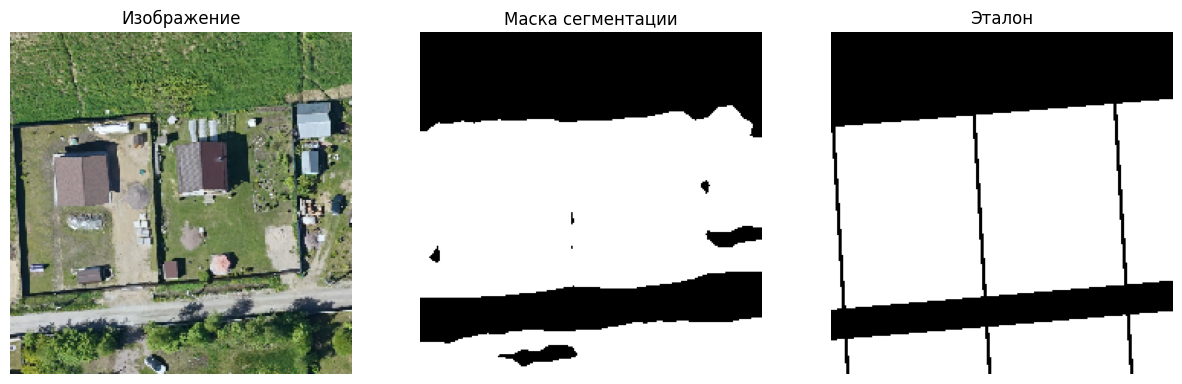

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=(15,15))
ax[0].imshow(subimage)
ax[0].axis('off')
ax[0].set_title('Изображение', fontsize=12)
ax[1].imshow(predicted_image_labeled)
ax[1].axis('off')
ax[1].set_title('Маска сегментации', fontsize=12)
ax[2].imshow(subimage_labeled)
ax[2].axis('off')
ax[2].set_title('Эталон', fontsize=12)
plt.show()